In [83]:
#Modern Neural Network, adapted from https://github.com/Newmu/Theano-Tutorials

import numpy as np
import theano
import random
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def rectify(X):
    return T.maximum(X, 0.)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))


class MLP(object):
    
    #Simplified RMSprop
    def RMSprop(self, cost, weights, lr = 0.001, rho = 0.9, eps = 1e-6):
        grads = T.grad(cost = cost, wrt = weights)
        updates = []
        
        for w, g in zip(weights, grads):
            acc = theano.shared(w.get_value()*0.)
            acc_new = rho * acc + (1 - rho) * g**2
            grad_scale = T.sqrt(acc_new + eps)
            g = g/grad_scale
            updates.append((acc, acc_new))
            updates.append((w, w - lr*g))
        
        return updates    
    
    #Random dropout for noise
    def dropout(self, X, P = 0.):
        if P > 0:
            X *= srng.binomial(X.shape, p = (1-P), dtype = theano.config.floatX)
            X /= (1-P)
        
        return X
        
    #Two hidden layer model
    def model(self, X, w_h1, w_h2, w_out, P_drop_i, P_drop_h):
        X = self.dropout(X, P_drop_i)
        h1 = rectify(T.dot(X, w_h1))
        
        h1 = self.dropout(h1, P_drop_h)
        h2 = rectify(T.dot(h1, w_h2))
        
        h2 = self.dropout(h2, P_drop_h)
        py_x = T.dot(h2, w_out)
        
        return h1, h2, py_x
    
    def __init__(self, n_in, n_h1, n_h2, n_out, lr, P_drop_i, P_drop_h):
        self.X = T.fmatrix()
        self.Y = T.fmatrix()
        
        #Init weights
        self.w_h1 = init_weights((n_in, n_h1))
        self.w_h2 = init_weights((n_h1, n_h2))
        self.w_out = init_weights((n_h2, n_out))
        print "Initializing Weights"
        #Init model
        self.noise_h, self.noise_h2, self.noise_py_x = \
        self.model(self.X, self.w_h1, self.w_h2, self.w_out, P_drop_i, P_drop_h)
        self.h1, self.h2, self.py_x = \
        self.model(self.X, self.w_h1, self.w_h2, self.w_out, 0., 0.)
        self.y_x_class = T.argmax(self.py_x, axis=1)
        self.y_x_value = T.max(self.py_x, axis=1)
        print "Initializing Model"
        
        #Cost and Updates
        self.cost = T.mean(T.nnet.categorical_crossentropy(self.noise_py_x, self.Y))
        self.weights = [self.w_h1, self.w_h2, self.w_out]
        self.updates = self.RMSprop(self.cost, self.weights, lr=lr)
        print "Cost and Updates Done!"
        
        #Compile to Theano functions
        self.train = theano.function(inputs = [self.X, self.Y],
                                     outputs = self.cost,
                                     updates = self.updates,
                                     allow_input_downcast = True)
        self.predict = theano.function(inputs = [self.X],
                                             outputs = [self.y_x_class, 
                                                        self.y_x_value,
                                                        self.py_x], 
                                             allow_input_downcast = True)
        print "Traing and Predicting Function Complete!"
        
        



In [119]:
#1010! Game with modifications
import random

class Game(object):
    def __init__(self):
        self.state = [[0 for i in range(10)] for j in range(10)]
        self.tiles = [[(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)],
                      [(0,0), (1,0), (2,0), (2,1), (2,2)],
                      [(0,0), (0,1), (0,2)],
                      [(0,0), (1,0), (2,0)],
                      [(0,0)],
                      [(0,0), (0,1)],
                      [(0,0), (1,0)],
                      [(0,0), (0,1), (1,0), (1,1)],
                      [(0,0), (0,1), (0,2), (1,0), (2,0)],
                      [(0,0), (0,1), (0,2), (1,2), (2,2)],
                      [(0,2), (1,2), (2,0), (2,1), (2,2)],
                      [(0,0), (0,1), (0,2), (0,3)],
                      [(0,0), (1,0), (2,0), (3,0)],
                      [(0,0), (1,0), (2,0), (3,0), (4,0)],
                      [(0,1), (1,0), (1,1)],
                      [(0,0), (0,1), (1,0)],
                      [(0,0), (0,1), (1,1)],
                      [(0,0), (1,0), (1,1)],
                      [(0,0), (0,1), (0,2), (0,3), (0,4)]]
        self.combo_score = [0 for i in range(10)]
        self.score = 0
        self.terminal = False
        self.valid_tile = [random.randint(0, 18) for i in range(3)]
        #Real Scores XD
        for i in xrange(1, 10):
            self.combo_score[i] = self.combo_score[i-1] + 10*i
        
    #Validate action
    def valid_action(self, action, tile):
        row, col = action
        valid_flag = True
        
        if(not tile in self.valid_tile):
            valid_flag = False
            return valid_flag
        
        for dr, dc in self.tiles[tile]:
            if(row + dr > 9 or col + dc > 9 or self.state[row + dr][col + dc] == 1):
                valid_flag = False
                break

        return valid_flag
            
    #Clear valid lines
    def update_state(self, clear_row, clear_col):
        for row in clear_row:
            for col in range(10):
                self.state[row][col] = 0
        
        for col in clear_col:
            for row in range(10):
                self.state[row][col] = 0
    
    #Calculate and clear lines
    def check_score(self):
        
        clear_lines = 0
        clear_row = []
        clear_col = []
        
        for row in xrange(10):
            row_flag = True
            for col in xrange(10):
                if(self.state[row][col] == 0):
                    row_flag = False
                    break
                
            if(row_flag == True):
                clear_row.append(row)
                clear_lines += 1
        
        for col in xrange(10):
            col_flag = True
            for row in xrange(10):
                if(self.state[row][col] == 0):
                    col_flag = False
                    break
            
            if(col_flag == True):
                clear_col.append(col)
                clear_lines += 1
        
        self.update_state(clear_row, clear_col)
        
        return self.combo_score[clear_lines]
        
    #Add the tile on specified coordinate, returns score
    def add_tile(self, action, tile):
        row, col = action
        if(self.valid_action(action, tile) == True):
            for dr, dc in self.tiles[tile]:
                self.state[row + dr][col + dc] = 1;
            
            return len(self.tiles[tile]) + self.check_score()
        
        else:
            return False
       
    def start_game(self):
        #print "Game Starts!"
        self.__init__()
        return self.score, self.state, self.valid_tile, self.terminal
    
    def end_game(self):
        end_flag = True
        for tile in self.valid_tile:
            for row in xrange(10):
                for col in xrange(10):
                    if(self.valid_action((row, col), tile)):
                        end_flag = False
                    
        return end_flag
    
    def do_action(self, action, tile):
        
        if(not tile in self.valid_tile):
            #print "Invalid Tile"
            pass
        else:
            temp_score = self.add_tile(action, tile)
            if(temp_score == False):
                #print "Invalid Action"
                pass
            else:
                self.score += temp_score
                self.valid_tile.remove(tile)
        
        if(self.valid_tile == []):
            self.valid_tile = [random.randint(0, 18) for i in range(3)]
        
        if(self.end_game() == True):
            self.terminal = True
            #print "Game Over"
        
        return self.score, self.state, self.valid_tile, self.terminal
    

        




In [120]:
#Deep Q Learning

def state_to_input(state, tiles):
    state = np.array(state)
    state_input = state.flatten()
    tile_input = np.zeros((19,))
    if type(tiles) == list:
        for i in tiles:
            tile_input[i] += 1
    
    state_input = np.append(state_input, tile_input)
    return state_input

def output_to_action(output, tiles):
    tile_idx = output/100
    output = output%100
    act = (output/10, output%10)
    tile = 0
    
    if type(tiles) == list:
        if(tile_idx > len(tiles)-1):
            tile = 19
        else:
            tile = tiles[tile_idx]
    
    return act, tile

class DeepQ(object):
    
    def __init__(self, n_in, n_h1, n_h2, n_out, lr, P_drop_i, P_drop_h):
        self.game = Game()
        self.nn = MLP(n_in, n_h1, n_h2, n_out, lr, P_drop_i, P_drop_h)
        self.exp = []

    def learn(self, n_epoch, exp_len, time_len, eps, gamma):
        train_score = []
        for e in xrange(n_epoch):
            
            #Start epoch
            score, state, valid_tile, terminal = self.game.start_game()
            
            for t in xrange(time_len):
                
                #Epsilon greedy
                policy_output = 0
                a_t = (0,0)
                tile_t = 0
                if(random.random() < eps):
                    for policy_t in xrange(300):
                        a_t, tile_t = output_to_action(policy_t, valid_tile)
                        if(self.game.valid_action(a_t, tile_t)):
                            policy_output = policy_t
                            break
                else:
                    pred = self.nn.predict([state_to_input(state, valid_tile)])
                    policy_outputs = sorted(range(len(pred[2][0])), key = lambda k:-pred[2][0][k])
                    #Choose Valid Policy with Max Q Value
                    for policy_t in policy_outputs:
                        a_t, tile_t = output_to_action(policy_t, valid_tile)
                        if(self.game.valid_action(a_t, tile_t)):
                            policy_output = policy_t
                            break
                    
                score_t, state_t, valid_tile_t, terminal = self.game.do_action(a_t, tile_t)
                reward = (score_t - score) - 0.5

                #Store Experience
                self.exp.append({'state':state, 
                                 'valid_tile':valid_tile, 
                                 'policy_output':policy_output,
                                 'reward':reward,
                                 'state_t':state_t,
                                 'valid_tile_t':valid_tile_t,
                                 'terminal':terminal})
                score = score_t
                state = state_t
                valid_tile = valid_tile_t
                
                #Experience Replay
                if(len(self.exp) > exp_len):
                    trX = []
                    trY = []
                    i = random.randint(0, exp_len-1)
                    if(self.exp[i]['terminal'] == True):
                        Q = self.exp[i]['reward']
                    else:
                        pred = self.nn.predict([state_to_input(self.exp[i]['state_t'],
                                                               self.exp[i]['valid_tile_t'])])
                        Q = self.exp[i]['reward'] + gamma * pred[1][0]
                        
                    y = pred[2][0]
                    y[self.exp[i]['policy_output']] = Q
                    trX.append(state_to_input(self.exp[i]['state'], self.exp[i]['valid_tile']))
                    trY.append(y)
                    del self.exp[i]
                    trX = np.asarray(trX)
                    trY = np.asarray(trY)
                    self.nn.train(trX, trY)

                if(terminal == True):
                    break
            train_score.append(score)
            #print "Learning Epoch: %d, Score: %d" % (e, score)
        
        return train_score
    
    def play(self, epoch):
        final_score = []
        for e in xrange(epoch):
            score, state, valid_tile, terminal = self.game.start_game()
            while(True):
                a_t = (0, 0)
                tile_t = 0
                pred = self.nn.predict([state_to_input(state, valid_tile)])
                policy_outputs = sorted(range(len(pred[2][0])), key = lambda k:-pred[2][0][k])
                
                for policy_t in policy_outputs:
                    a_t, tile_t = output_to_action(policy_t, valid_tile)
                    if(self.game.valid_action(a_t, tile_t)):
                        break
                    
                
                score, state, valid_tile, terminal = self.game.do_action(a_t, tile_t)
                
                if(terminal == True):
                    break
                    
            final_score.append(score)
            print "Playing epoch: %d, Score: %d" % (e, score)
            
        return final_score
        
        

Initializing Weights
Initializing Model
Cost and Updates Done!
Traing and Predicting Function Complete!
101.6226


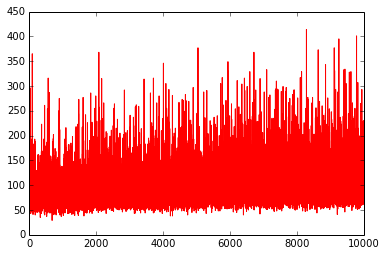

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

Learner = DeepQ(119, 128, 128, 300, 0.001, 0, 0)
graph_y = Learner.learn(10000, 1000, 3000, 0.1, 0.99)
graph_x = [i for i in range(10000)] 
print np.average(graph_y)
plt.plot(graph_x, graph_y, 'r-')

Playing epoch: 0, Score: 160
Playing epoch: 1, Score: 55
Playing epoch: 2, Score: 90
Playing epoch: 3, Score: 135
Playing epoch: 4, Score: 84
Playing epoch: 5, Score: 122
Playing epoch: 6, Score: 177
Playing epoch: 7, Score: 110
Playing epoch: 8, Score: 80
Playing epoch: 9, Score: 98
Playing epoch: 10, Score: 56
Playing epoch: 11, Score: 109
Playing epoch: 12, Score: 155
Playing epoch: 13, Score: 65
Playing epoch: 14, Score: 120
Playing epoch: 15, Score: 81
Playing epoch: 16, Score: 130
Playing epoch: 17, Score: 158
Playing epoch: 18, Score: 256
Playing epoch: 19, Score: 132
Playing epoch: 20, Score: 65
Playing epoch: 21, Score: 186
Playing epoch: 22, Score: 90
Playing epoch: 23, Score: 175
Playing epoch: 24, Score: 81
Playing epoch: 25, Score: 229
Playing epoch: 26, Score: 58
Playing epoch: 27, Score: 101
Playing epoch: 28, Score: 96
Playing epoch: 29, Score: 114
Playing epoch: 30, Score: 59
Playing epoch: 31, Score: 112
Playing epoch: 32, Score: 172
Playing epoch: 33, Score: 61
Playi

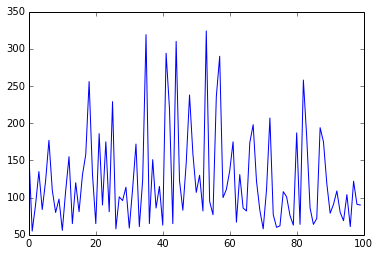

In [138]:
graph_y = Learner.play(100)
graph_x = [i for i in range(100)] 
print np.average(graph_y)
plt.plot(graph_x, graph_y, 'b-')

In [135]:
print Learner.nn.w_h1.get_value()
print Learner.nn.w_h2.get_value()
print Learner.nn.w_out.get_value()

[[  1.85986780e+02   1.77437488e+02   1.86324782e+02 ...,   1.84195642e+02
    1.86323277e+02   1.86298703e+02]
 [  1.75559282e+02   1.67631358e+02   1.75869948e+02 ...,   1.73961728e+02
    1.75871864e+02   1.75863616e+02]
 [  1.53323315e+02   1.47807036e+02   1.53572529e+02 ...,   1.52125581e+02
    1.53550353e+02   1.53546718e+02]
 ..., 
 [  2.22783419e-01   2.01651005e-01   2.24064813e-01 ...,   2.19624343e-01
    2.20126918e-01   2.27483291e-01]
 [  1.79855734e-01   1.59845730e-01   1.79740992e-01 ...,   1.69146060e-01
    1.62870196e-01   1.78234752e-01]
 [  5.74732939e+00   5.33165499e+00   5.77185389e+00 ...,   5.65888550e+00
    5.77480601e+00   5.75683812e+00]]
[[  1.13022695e-02   2.13165456e+02   5.87650319e-04 ...,   1.96675004e-02
    1.27029136e-02   2.11517728e+02]
 [ -1.14935270e-02   2.02975438e+02  -8.04340533e-03 ...,  -1.91300510e-02
    2.92982989e-03   2.02946423e+02]
 [  1.35680792e-03   2.13510437e+02  -3.19722959e-03 ...,  -5.28805592e-03
   -1.54536160e-03   